In [3]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, TimeDistributed, Masking
from tensorflow.keras.optimizers import Adam
import h5py
import matplotlib.pyplot as plt
import numpy.ma as ma

In [4]:
from matplotlib.pyplot import figure
plt.rcParams["figure.figsize"] = (20,12)
figure(figsize=(100, 80), dpi=80)

<Figure size 8000x6400 with 0 Axes>

<Figure size 8000x6400 with 0 Axes>

In [5]:
tf.random.set_seed(12345)

In [6]:
# pip install -U numpy==1.18.5

In [7]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [8]:
f = h5py.File("alipark_processed_data.h5","r")
scaled_X = ma.array(f["scaled_x"])
scaled_X.mask = ma.array(f["x_mask"])
minX = np.array(f["minX"])
maxX = np.array(f["maxX"])
f.close()

In [9]:
scaled_X

masked_array(
  data=[[0.17119565217391305],
        [0.1467391304347826],
        [0.17119565217391305],
        [0.1141304347826087],
        [0.14130434782608697],
        [0.10869565217391305],
        [0.13586956521739132],
        [0.12771739130434784],
        [0.05706521739130435],
        [0.08695652173913045],
        [0.04891304347826087],
        [0.09782608695652174],
        [0.05706521739130435],
        [0.16847826086956524],
        [0.125],
        [0.125],
        [0.14130434782608697],
        [0.14402173913043478],
        [0.1847826086956522],
        [0.2282608695652174],
        [0.32608695652173914],
        [0.3369565217391305],
        [0.38315217391304357],
        [0.4239130434782609],
        [0.36956521739130443],
        [0.3967391304347827],
        [0.3315217391304348],
        [0.2989130434782609],
        [0.37500000000000006],
        [0.34239130434782616],
        [0.38315217391304357],
        [0.3125],
        [0.34510869565217395],
        [0.23

In [10]:
def inverse_scaler(scaled_x,minX,maxX):
    return scaled_x*maxX-minX

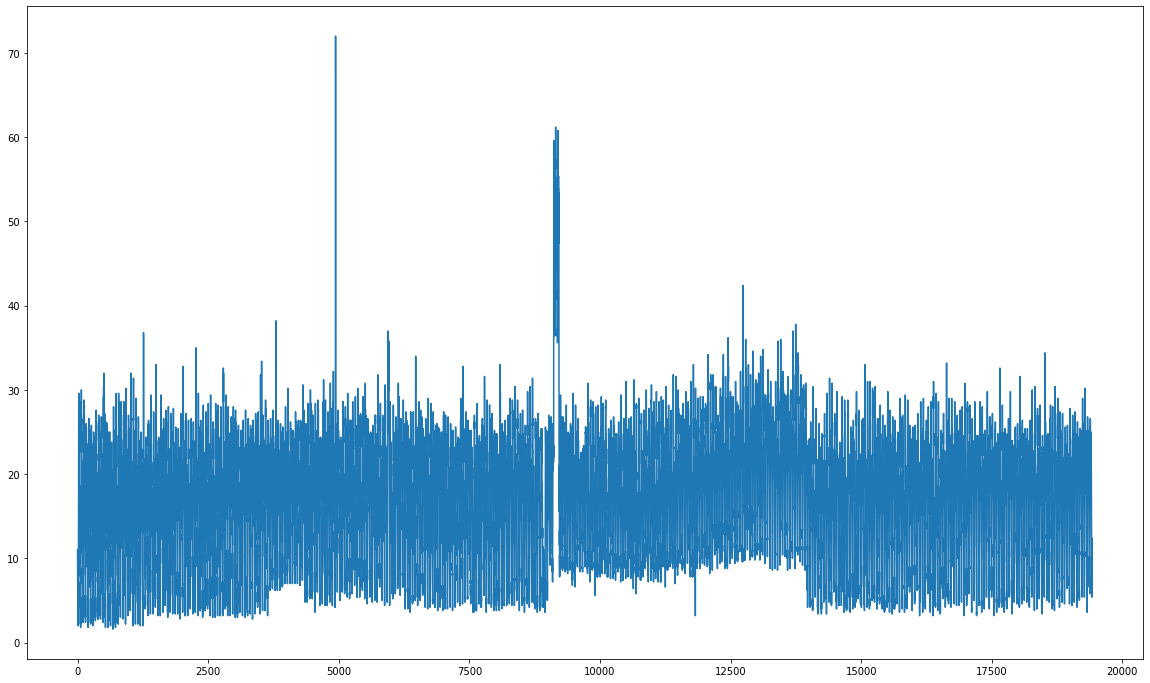

In [11]:
plt.plot(inverse_scaler(scaled_X,minX,maxX))
plt.show()

In [12]:
def partitionSet(test_fraction, data, partitions):
    lenX = len(data)
    test_size = int(len(data) * test_fraction)
    test_df = data[int((partitions/100)*lenX):int((partitions/100)*lenX)+test_size]
    train_df = ma.vstack((data[:int((partitions/100)*lenX)-1],data[int((partitions/100)*lenX)+test_size:]))
    train_df[int((partitions/100)*lenX)] = ma.masked
    return train_df, test_df

train_dataf = []
test_dataf = []

partitions=75

for i in range(1, partitions):
    [train_df,test_df] = partitionSet(0.25,scaled_X,i)
    train_dataf.append(train_df)
    test_dataf.append(test_df)

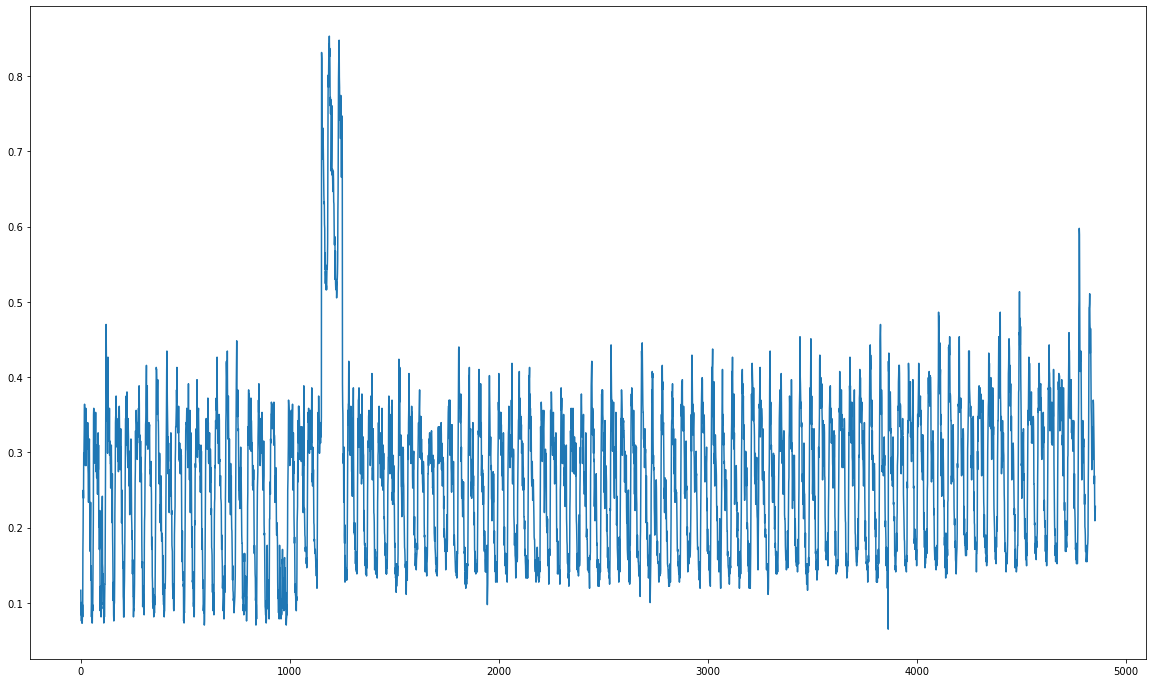

In [18]:
plt.plot(test_dataf[40])
plt.show()

In [12]:
def Dataset(train, test, timesteps):
    X_train = ma.array([train[t:t+timesteps] for t in range(0,len(train)-timesteps)])
    y_train = train[timesteps:, :]
    X_test = ma.array([test[t:t+timesteps] for t in range(0,len(test)-timesteps)])
    y_test = test[timesteps:, :]
    return X_train, y_train, X_test, y_test

train_X_data = []
train_Y_data = []
test_X_data = []
test_Y_data = []


for j in range(0, len(train_dataf)):
    [train_X_dates,train_Y_dates,test_X_dates,test_Y_dates]=Dataset(train_dataf[j],test_dataf[j], 24)
    train_X_data.append(train_X_dates)
    train_Y_data.append(train_Y_dates)
    test_X_data.append(test_X_dates)
    test_Y_data.append(test_Y_dates)

In [13]:
with open('train_X_data.npy', 'wb') as f:
    np.save(f, [train_X_data[i] for i in range(0, len(train_dataf))])

In [14]:
with open('train_Y_data.npy', 'wb') as f:
    np.save(f, [train_Y_data[i] for i in range(0, len(train_dataf))])

In [15]:
with open('test_X_data.npy', 'wb') as f:
    np.save(f, [test_X_data[i] for i in range(0, len(train_dataf))])

In [16]:
with open('test_Y_data.npy', 'wb') as f:
    np.save(f, [test_Y_data[i] for i in range(0, len(train_dataf))])

In [17]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping()

In [18]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience=6, min_delta=0.00001, mode='min')

In [19]:
def LSTM_function(NCells, timesteps, num_features, dropout, NBEpochs, Batchsize, validationSplit, earlystopping, i):
    model = Sequential()
    model.add(Masking(mask_value=0., input_shape=(timesteps, num_features)))
    model.add(LSTM(1, activation = 'tanh', input_shape = (timesteps, num_features), return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(NCells))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(loss = 'mse', optimizer='adam')
    X_ = ma.filled(train_X_data[i],0)
    Y_ = ma.filled(train_Y_data[i],0)
    MODEL = model.fit(X_, Y_, epochs = NBEpochs, batch_size = Batchsize,
                      validation_split = validationSplit, shuffle = False,
                      callbacks=[earlystopping])
    return model, MODEL

In [20]:
train_X_data[0].shape

(14542, 24, 1)

In [ ]:
df_train = []
df_validation = []
models = []
MODELS = []

datasets = np.arange(0,partitions-1)

for j in datasets:
    [model, MODEL] = LSTM_function(64,np.shape(train_X_data[0])[1], 1, 0.1, 200, 128, 0.2, early_stopping, j)
    df_train.append(MODEL.history['loss'])
    df_validation.append(MODEL.history['val_loss'])
    models.append(model)
    MODELS.append(MODEL)

Epoch 1/200
91/91 [==============================] - 9s 29ms/step - loss: 0.0141 - val_loss: 0.0099
Epoch 2/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0109 - val_loss: 0.0094
Epoch 3/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0105 - val_loss: 0.0091
Epoch 4/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0100 - val_loss: 0.0084
Epoch 5/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0094 - val_loss: 0.0075
Epoch 6/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0082 - val_loss: 0.0064
Epoch 7/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0069 - val_loss: 0.0053
Epoch 8/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0058 - val_loss: 0.0046
Epoch 9/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0052 - val_loss: 0.0040
Epoch 10/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0046 - val_loss: 0.0044

91/91 [==============================] - 1s 12ms/step - loss: 0.0016 - val_loss: 9.6407e-04
Epoch 67/200
91/91 [==============================] - 1s 12ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 68/200
91/91 [==============================] - 1s 12ms/step - loss: 0.0016 - val_loss: 9.4863e-04
Epoch 69/200
91/91 [==============================] - 1s 12ms/step - loss: 0.0016 - val_loss: 9.6736e-04
Epoch 70/200
91/91 [==============================] - 1s 12ms/step - loss: 0.0016 - val_loss: 9.6537e-04
Epoch 71/200
91/91 [==============================] - 1s 12ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 72/200
91/91 [==============================] - 1s 12ms/step - loss: 0.0015 - val_loss: 9.4674e-04
Epoch 73/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0016 - val_loss: 9.9798e-04
Epoch 74/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0016 - val_loss: 9.7095e-04
Epoch 1/200
91/91 [==============================] - 7s 29ms/step - loss: 0.

Epoch 78/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0017 - val_loss: 9.9704e-04
Epoch 1/200
91/91 [==============================] - 7s 27ms/step - loss: 0.0134 - val_loss: 0.0086
Epoch 2/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0095 - val_loss: 0.0076
Epoch 3/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0087 - val_loss: 0.0063
Epoch 4/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0075 - val_loss: 0.0052
Epoch 5/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0065 - val_loss: 0.0046
Epoch 6/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0057 - val_loss: 0.0041
Epoch 7/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0052 - val_loss: 0.0037
Epoch 8/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0047 - val_loss: 0.0033
Epoch 9/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0044 - val_loss: 0.

91/91 [==============================] - 1s 12ms/step - loss: 0.0053 - val_loss: 0.0036
Epoch 7/200
91/91 [==============================] - 1s 12ms/step - loss: 0.0047 - val_loss: 0.0031
Epoch 8/200
91/91 [==============================] - 1s 12ms/step - loss: 0.0043 - val_loss: 0.0029
Epoch 9/200
91/91 [==============================] - 1s 12ms/step - loss: 0.0039 - val_loss: 0.0026
Epoch 10/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0037 - val_loss: 0.0024
Epoch 11/200
91/91 [==============================] - 1s 12ms/step - loss: 0.0034 - val_loss: 0.0022
Epoch 12/200
91/91 [==============================] - 1s 12ms/step - loss: 0.0032 - val_loss: 0.0021
Epoch 13/200
91/91 [==============================] - 1s 12ms/step - loss: 0.0030 - val_loss: 0.0019
Epoch 14/200
91/91 [==============================] - 1s 12ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 15/200
91/91 [==============================] - 1s 12ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 

91/91 [==============================] - 1s 11ms/step - loss: 0.0017 - val_loss: 9.6791e-04
Epoch 93/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0017 - val_loss: 9.8959e-04
Epoch 94/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 95/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0017 - val_loss: 9.8646e-04
Epoch 96/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0016 - val_loss: 9.7135e-04
Epoch 97/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0017 - val_loss: 9.5875e-04
Epoch 98/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0016 - val_loss: 9.8358e-04
Epoch 1/200
91/91 [==============================] - 7s 28ms/step - loss: 0.0142 - val_loss: 0.0090
Epoch 2/200
91/91 [==============================] - 1s 12ms/step - loss: 0.0106 - val_loss: 0.0092
Epoch 3/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0104 -

91/91 [==============================] - 8s 37ms/step - loss: 0.0099 - val_loss: 0.0060
Epoch 2/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0065 - val_loss: 0.0045
Epoch 3/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0057 - val_loss: 0.0037
Epoch 4/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0048 - val_loss: 0.0032
Epoch 5/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0045 - val_loss: 0.0030
Epoch 6/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0041 - val_loss: 0.0028
Epoch 7/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0040 - val_loss: 0.0026
Epoch 8/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0038 - val_loss: 0.0025
Epoch 9/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0036 - val_loss: 0.0023
Epoch 10/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0034 - val_loss: 0.0022
Epoch 11/20

91/91 [==============================] - 1s 10ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 18/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 19/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 20/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 21/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 22/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 23/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 24/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 25/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 26/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0020 - val_loss: 0.0014
Epo

Epoch 26/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 27/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 28/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0026 - val_loss: 0.0020
Epoch 29/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 30/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 31/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 32/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 33/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 34/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 35/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0023 - val_los

91/91 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 50/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 51/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 52/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 53/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 54/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 55/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 56/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 57/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 58/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0017 - val_loss: 9.9229e-04

Epoch 62/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 63/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 64/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 65/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 66/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 67/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 68/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 69/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 70/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 71/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0018 - val_los

Epoch 45/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 46/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 47/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 48/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 49/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 50/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 51/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 52/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 53/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 54/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0019 - val_los

91/91 [==============================] - 1s 11ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 13/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0032 - val_loss: 0.0021
Epoch 14/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0031 - val_loss: 0.0021
Epoch 15/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0031 - val_loss: 0.0020
Epoch 16/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0030 - val_loss: 0.0019
Epoch 17/200
91/91 [==============================] - 1s 12ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 18/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 19/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 20/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 21/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0027 - val_loss: 0.0016
Epo

91/91 [==============================] - 1s 11ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 24/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 25/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0027 - val_loss: 0.0021
Epoch 26/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0027 - val_loss: 0.0021
Epoch 27/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0028 - val_loss: 0.0020
Epoch 28/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 29/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 30/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 31/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 32/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0025 - val_loss: 0.0017
Epo

Epoch 15/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 16/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 17/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 18/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 19/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0026 - val_loss: 0.0020
Epoch 20/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 21/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 22/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 23/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 24/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0024 - val_los

Epoch 27/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 28/200
91/91 [==============================] - 1s 12ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 29/200
91/91 [==============================] - 1s 12ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 30/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 31/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 32/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 33/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 34/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 35/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 36/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0016 - val_los

91/91 [==============================] - 1s 10ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 26/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 27/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 28/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 29/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 30/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 31/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 32/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 33/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 34/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 0.0012
Epo

Epoch 27/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 28/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 29/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 30/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 31/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 32/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 33/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 34/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 35/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 36/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0019 - val_loss:

91/91 [==============================] - 1s 9ms/step - loss: 0.0039 - val_loss: 0.0030
Epoch 8/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0035 - val_loss: 0.0028
Epoch 9/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 10/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0030 - val_loss: 0.0024
Epoch 11/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 0.0022
Epoch 12/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 13/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 14/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 15/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 16/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 17/200
91

Epoch 35/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 36/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 37/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 38/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 39/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 40/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 41/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0017 - val_loss: 9.7225e-04
Epoch 42/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 43/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0017 - val_loss: 9.7250e-04
Epoch 44/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0016 - v

91/91 [==============================] - 1s 8ms/step - loss: 0.0016 - val_loss: 9.2964e-04
Epoch 70/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0016 - val_loss: 9.2989e-04
Epoch 71/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0016 - val_loss: 9.2815e-04
Epoch 72/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0015 - val_loss: 9.4258e-04
Epoch 1/200
91/91 [==============================] - 8s 30ms/step - loss: 0.0100 - val_loss: 0.0053
Epoch 2/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0052 - val_loss: 0.0034
Epoch 3/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0044 - val_loss: 0.0031
Epoch 4/200
91/91 [==============================] - 1s 11ms/step - loss: 0.0041 - val_loss: 0.0028
Epoch 5/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0038 - val_loss: 0.0025
Epoch 6/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0035 - val_loss: 0.00

Epoch 24/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 25/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 26/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 27/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 28/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 29/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 30/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 31/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 32/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 33/200
91/91 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 0.0010

91/91 [==============================] - 1s 9ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 27/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 28/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 29/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 30/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 31/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 32/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 33/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 34/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 35/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 36/200


Epoch 29/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 30/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0019 - val_loss: 0.0010
Epoch 31/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 32/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0019 - val_loss: 0.0010
Epoch 33/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 34/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0018 - val_loss: 9.8936e-04
Epoch 35/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0018 - val_loss: 9.9883e-04
Epoch 36/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 37/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0018 - val_loss: 9.8980e-04
Epoch 38/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0018 - val_l

91/91 [==============================] - 1s 9ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 17/200
91/91 [==============================] - 1s 8ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 18/200
91/91 [==============================] - 1s 8ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 19/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 20/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 21/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 22/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 23/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 24/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 25/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 26/200


Epoch 23/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 24/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 25/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 26/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0017 - val_loss: 9.8570e-04
Epoch 27/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 28/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0017 - val_loss: 9.8383e-04
Epoch 29/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0017 - val_loss: 9.4639e-04
Epoch 30/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0017 - val_loss: 9.6254e-04
Epoch 31/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0016 - val_loss: 9.2869e-04
Epoch 32/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0017

91/91 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 0.0016
Epoch 11/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0027 - val_loss: 0.0016
Epoch 12/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 13/200
91/91 [==============================] - 1s 9ms/step - loss: 0.0024 - val_loss: 0.0013
Epoch 14/200
15/91 [===>..........................] - ETA: 0s - loss: 0.0022

In [ ]:
for i in datasets:
    models[i].save('/home/costa/JoaoModelsForAlicante/AliPark/models/AliParkModel'+str(i)+'.h5')

In [ ]:
for i in datasets:
    MODELS[i].save('/home/costa/JoaoModelsForAlicante/AliPark/MODELS/AliParkModel'+str(i)+'.h5')

In [ ]:
train_performance = []
for i in datasets:
    train_performance.append(np.array(df_train[i]))

In [ ]:
val_performance = []
for i in datasets:
    val_performance.append(np.array(df_validation[i]))

In [ ]:
with open('train_performance.npy', 'wb') as f:
    np.save(f, [train_performance[i] for i in datasets])

In [ ]:
with open('val_performance.npy', 'wb') as f:
    np.save(f, [val_performance[i] for i in datasets])

In [1]:
import re #python regular expression matching module
script = re.sub(r'# In\[.*\]:\n','',open('3.0-Model.py').read())
with open('3.0-ModelScript.py','w') as fh:
    fh.write(script)